## data source
* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [1]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4 # how much memory to occupy
config.gpu_options.visible_device_list = "3,5"
set_session(tf.Session(config=config)) # we will create our session with the gpu id specified



Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('./data/fer2013/fer2013.csv')

(array([4953.,  547.,    0., 5121.,    0., 8989., 6077.,    0., 4002.,
        6198.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

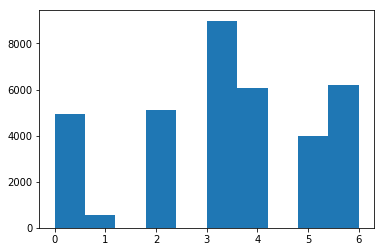

In [4]:
plt.hist(df['emotion'])

### We are going to combine disgust(label 1) with sad(label 4)

In [5]:
df.loc[df['emotion']==1, 'emotion'] = 4

(array([4953.,    0.,    0., 5121.,    0., 8989., 6624.,    0., 4002.,
        6198.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

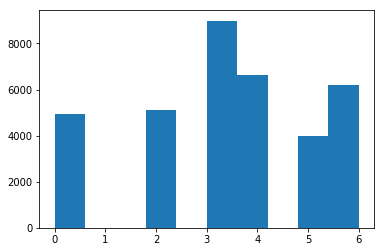

In [6]:
plt.hist(df['emotion'])

In [7]:
def update(row):
    if row.loc['emotion'] != 0:
        row.loc['emotion'] -= 1
    return row
df_updated = df.apply(update, axis=1)

(array([4953.,    0., 5121.,    0., 8989.,    0., 6624.,    0., 4002.,
        6198.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

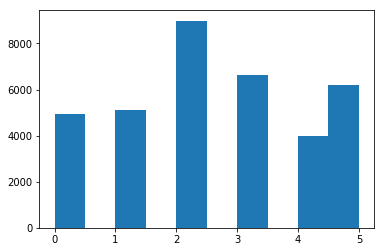

In [8]:
plt.hist(df_updated['emotion'])

In [9]:
emotion_str_to_id = {'angry': 0, 'fear':1, 'happy':2, 'sad':3, 'surprise':4, 'neutral':5}
emotion_id_to_str = {v:k for k,v in emotion_str_to_id.items()}

In [10]:
df_updated.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,1,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
len(df_updated.iloc[0]['pixels'])

8287

In [12]:
set([len(pix_str.split(' ')) for pix_str in df_updated['pixels']])

{2304}

Now we confirm the image shapes are all 2304 (48*48)

### split data into training and test

* We will use PrivateTest as test split
* We augment training split by flipping images horizentally

In [13]:
df_updated.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [14]:
n_train_samples = (df_updated.Usage.value_counts()['Training']+df_updated.Usage.value_counts()['PublicTest']) * 2
train_images = np.zeros((n_train_samples, 48, 48), dtype=np.int32)
train_labels = np.zeros((n_train_samples), dtype=np.int32)

n_test_samples = df_updated.Usage.value_counts()['PrivateTest']
test_images = np.zeros((n_test_samples, 48, 48), dtype=np.int32)
test_labels = np.zeros((n_test_samples), dtype=np.int32)


i = 0
j = 0
for _, row in df_updated.iterrows():
    emotion_id = row['emotion']
    face_img = np.reshape(np.array(row['pixels'].split(' ')), (48, 48))
    
    if row['Usage'] != 'PrivateTest':
        train_images[i] = face_img
        train_labels[i] = emotion_id


        train_images[n_train_samples-i-1] = np.fliplr(face_img)
        train_labels[n_train_samples-i-1] = emotion_id
        
        i += 1
    else:
        test_images[j] = face_img
        test_labels[j] = emotion_id
        
        j += 1
        


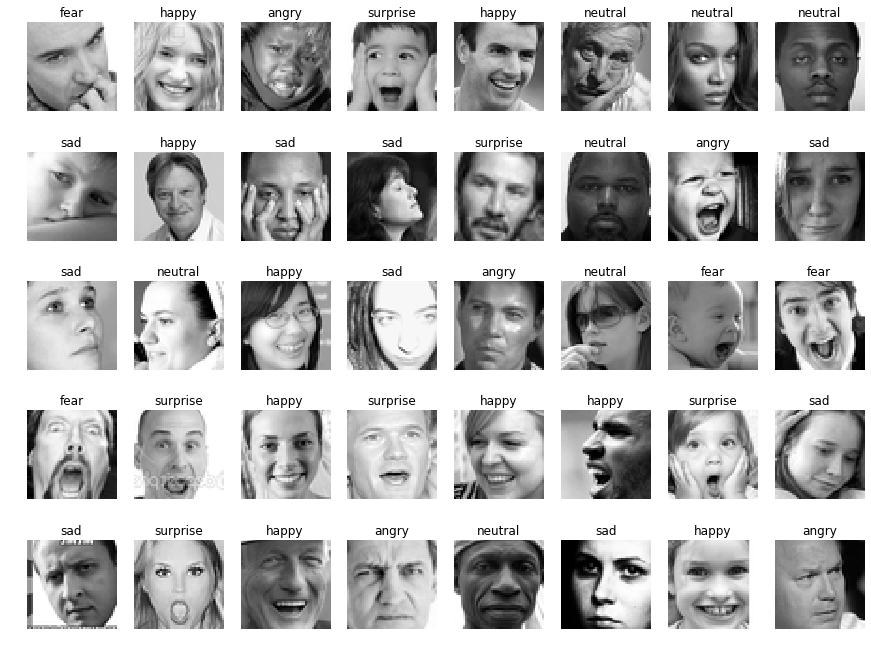

In [15]:
# show random training images
cols = 8
rows = 5
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(train_images[random_index, :], cmap='gray')
        ax.set_title(emotion_id_to_str[train_labels[random_index]])
plt.show()

# Prepare Data

normalize inputs: $$x_{norm} = \frac{x}{255} - 0.5$$

In [16]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# normalize inputs
x = train_images / 255 - 0.5
x = x.reshape((len(x), 48, 48, 1))
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y = to_categorical(train_labels)


split

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, shuffle=True)

In [18]:
print("Train samples:", x_train.shape, y_train.shape)
print("Valid samples:", x_val.shape, y_val.shape)
print("Test samples [unprocessed]:", test_images.shape, test_labels.shape)

Train samples: (54906, 48, 48, 1) (54906, 6)
Valid samples: (9690, 48, 48, 1) (9690, 6)
Test samples [unprocessed]: (3589, 48, 48) (3589,)


In [19]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import keras

In [20]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    
    # one way of defining the model
    model = Sequential()

    model.add(Conv2D(16, 3, padding='valid', input_shape=(48, 48, 1)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, 3, padding='valid'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.15))
    
    model.add(Conv2D(128, 3, padding='valid'))
    model.add(LeakyReLU(0.1))
    
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, 3, padding='valid'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(16, 3, padding='valid'))
    model.add(LeakyReLU(0.1))
    
    model.add(Flatten())
    
    model.add(BatchNormalization())

    model.add(Dense(256))
    model.add(LeakyReLU(0.1))

    model.add(Dropout(0.3))

    model.add(Dense(6))
    model.add(Activation('softmax'))
        
    return model

In [21]:
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        9280      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
__________

In [22]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 50


model.compile(
    loss='categorical_crossentropy',  
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  
    metrics=['accuracy']  
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", keras.backend.get_value(model.optimizer.lr))

In [23]:
model_filename = 'emotion_simple.h5'
# fit model
training = model.fit(
                x_train, y_train,  # prepared data
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
                           LrHistory(), 
                           keras.callbacks.ModelCheckpoint(model_filename, save_best_only=True)],
                validation_data=(x_val, y_val),
                shuffle=True,
                verbose=1
            )

Train on 54906 samples, validate on 9690 samples
Epoch 1/50
Learning rate: 0.005
54906/54906 [==============================] - 18s 321us/step - loss: 1.5281 - acc: 0.4117 - val_loss: 1.3065 - val_acc: 0.4917
Epoch 2/50
Learning rate: 0.0045
54906/54906 [==============================] - 14s 259us/step - loss: 1.2296 - acc: 0.5194 - val_loss: 1.1998 - val_acc: 0.5327
Epoch 3/50
Learning rate: 0.00405
54906/54906 [==============================] - 14s 257us/step - loss: 1.1463 - acc: 0.5556 - val_loss: 1.1497 - val_acc: 0.5533
Epoch 4/50
Learning rate: 0.003645
54906/54906 [==============================] - 14s 260us/step - loss: 1.0782 - acc: 0.5827 - val_loss: 1.0562 - val_acc: 0.5941
Epoch 5/50
Learning rate: 0.0032805
54906/54906 [==============================] - 14s 249us/step - loss: 1.0284 - acc: 0.6008 - val_loss: 1.0301 - val_acc: 0.6044
Epoch 6/50
Learning rate: 0.00295245
54906/54906 [==============================] - 14s 251us/step - loss: 0.9827 - acc: 0.6209 - val_loss: 1

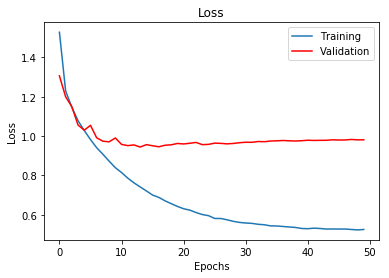

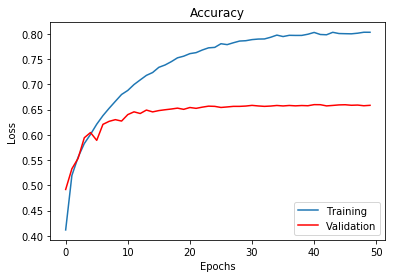

In [24]:
loss = training.history['loss']
val_loss = training.history['val_loss']
acc = training.history['acc']
val_acc = training.history['val_acc']

# loss plot
tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

In [25]:
# prepare test data
# normalize inputs
x_test = test_images / 255 - 0.5
x_test = x_test.reshape((len(x_test), 48, 48, 1))
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_test = to_categorical(test_labels)


# make test predictions
model = load_model(model_filename) # load the best checkpoint
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# y_pred_test_max_probas = np.max(y_pred, axis=1)

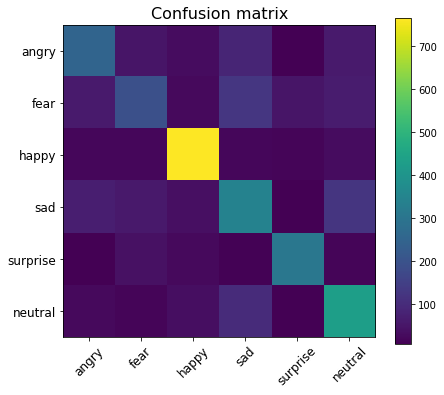

Test accuracy: 0.6402897743103929


In [26]:
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(test_labels, y_pred_classes))
plt.xticks(np.arange(6), emotions, rotation=45, fontsize=12)
plt.yticks(np.arange(6), emotions, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(test_labels, y_pred_classes))